In [1]:
import findspark
findspark.init()

import pyspark.sql.types as T
import pyspark.sql.functions as F

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

from etl import SparkETL
from dim import RouteDim

In [2]:
etl = SparkETL()
spark = etl.get_spark()
dim_helper = RouteDim()

22/05/13 19:04:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
immigration = etl.read_clean_table('immigration')

In [4]:
def route_nk(df):
    return (
        df
        .select(dim_helper.get_nk())
        .drop_duplicates()
    )

In [5]:
def missing_routes(df):
    
    route_dim = etl.read_dim_table('route_dim')
    
    return (
        df
        .join(
            route_dim,
            on=dim_helper.on_nk(df, route_dim),
            how='leftanti'
        )
    )

In [6]:
def coordinate_expr(index):
    return F.expr(f"""
            CAST(
                ELEMENT_AT(
                    SPLIT(dst_coordinates, ','), 
                    {index}
                ) 
                AS DOUBLE
            )
        """)

In [7]:
def fill_sk(df):
    return df.withColumn('route_id', F.expr(dim_helper.gen_sk_expr()))

In [8]:
def fill_airport(df):
    
    airports = (
        etl.read_clean_table('airport')
        .withColumnRenamed('airport_id', 'dst_airport_id')
    )
    
    ports_to_airports = (
        etl.read_clean_table('port_to_airport')
        .withColumnRenamed('port_id', 'airport_port_id')
    )
    
    return (
        df
        .join(
            ports_to_airports,
            on=df['port_id'] == ports_to_airports['airport_port_id'],
            how='left'
        )
        .drop('airport_port_id')
        .join(
            airports,
            on=ports_to_airports['airport_id'] == airports['dst_airport_id'],
            how='left'
        )
        .drop('airport_id')
        .withColumnRenamed('city', 'dst_city')
        .withColumnRenamed('state_id', 'dst_state_id')
        .withColumnRenamed('name', 'dst_airport_name')
        .withColumnRenamed('international', 'dst_airport_international')
        .withColumnRenamed('type_id', 'dst_airport_type_id')
        .withColumnRenamed('type', 'dst_airport_type')
        .withColumnRenamed('coordinates', 'dst_coordinates')
        .withColumn('dst_longitude', coordinate_expr(1))
        .withColumn('dst_latitude', coordinate_expr(2))
    )

In [9]:
def fill_demographics(df):
    
    demographics = etl.read_clean_table('demographics')
    
    return (
        df
        .join(
            demographics,
            on=(
                (df['dst_state_id'] == demographics['state_id'])
                & (df['dst_city'] == demographics['city'])
            ),
            how='left'
        )
        .drop('state_id', 'city')
        .withColumnRenamed('asian', 'dst_asian')
        .withColumnRenamed('black', 'dst_black')
        .withColumnRenamed('latino', 'dst_latino')
        .withColumnRenamed('native', 'dst_native')
        .withColumnRenamed('white', 'dst_white')
        .withColumnRenamed('ethnicity_id', 'dst_ethnicity_id')
        .withColumnRenamed('ethnicity', 'dst_ethnicity')
        .withColumnRenamed('population', 'dst_population')
        .withColumnRenamed('size_id', 'dst_size_id')
        .withColumnRenamed('size', 'dst_size')
    )

In [10]:
def fill_state(df):
    
    states = etl.read_clean_table('state')
    
    return (
        df
        .join(states, on=df['dst_state_id'] == states['state_id'], how='left')
        .drop('state_id')
        .withColumnRenamed('name', 'dst_state_name')
        .withColumnRenamed('type_id', 'dst_state_type_id')
        .withColumnRenamed('type', 'dst_state_type')
    )

In [11]:
def fill_temperature(df):
    
    temperatures = etl.read_clean_table('temperature')
    
    return (
        df
        .join(temperatures, on=df['dst_state_id'] == temperatures['state_id'], how='left')
        .drop('state_id')
        .withColumnRenamed('climate_id', 'dst_state_climate_id')
        .withColumnRenamed('climate', 'dst_state_climate')
    )

In [12]:
def fill_missing_routes(df, date):
    return (
        df
        .pipe(SparkETL.filter_one_month, date)
        .pipe(route_nk)
        .pipe(missing_routes)
        .pipe(fill_sk)
        .pipe(fill_airport)
        .pipe(fill_demographics)
        .pipe(fill_state)
        .pipe(fill_temperature)
    )

In [13]:
etl.save_dim_table(
    immigration.pipe(fill_missing_routes, date),
    'route_dim'
)

TypeError: fill_missing_routes() missing 1 required positional argument: 'date'

In [17]:
from datetime import datetime

for month in range(1,13):
    date = f"2016-{month:02d}-01"
    print(date)
    etl.save_dim_table(
        immigration.pipe(fill_missing_routes, date),
        'route_dim'
    )

2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01


In [15]:
route_dim = etl.read_dim_table('route_dim')

In [18]:
route_dim.count()

109061

In [19]:
#TODO: validation, no sk dups, could also check to nk dups
(
    route_dim
    .select('route_id')
    .count() == route_dim.select('route_id').drop_duplicates().count()
)

True

NOTE: use entity resolution for airport_to_city

Exhibit that doesn't match any city
```
Chicago/West Chicago airport municipality
```

In [93]:
col = 'dst_state_climate'

<AxesSubplot:ylabel='dst_state_climate'>

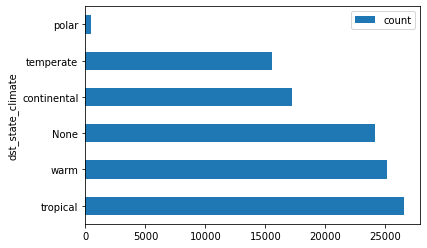

In [94]:
(
    route_dim
    .groupby(col)
    .count()
    .sort(F.desc('count'))
).limit(1000).toPandas().iloc[:20].plot(x=col, y='count', kind='barh')

In [62]:
route_dim.where(F.col('flight_number') == 'UNKNOWN').count()

916